Импорт библиотек
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.signal import find_peaks

 Загрузка и подготовка данных
 ---

In [2]:
# Загружаем файл
data = pd.read_csv('Run200_Wave_0_1.txt', sep=' ', header=None, skipinitialspace=True)
print(f'Размер исходных данных: {data.shape}')

# Удаляем метаинформацию
data = data.drop([0, 1, 2, 3, 504], axis=1)
data.columns = list(range(500))

Размер исходных данных: (23479, 505)


Визуализация исходных сигналов и Калибровка (инверсия)
---

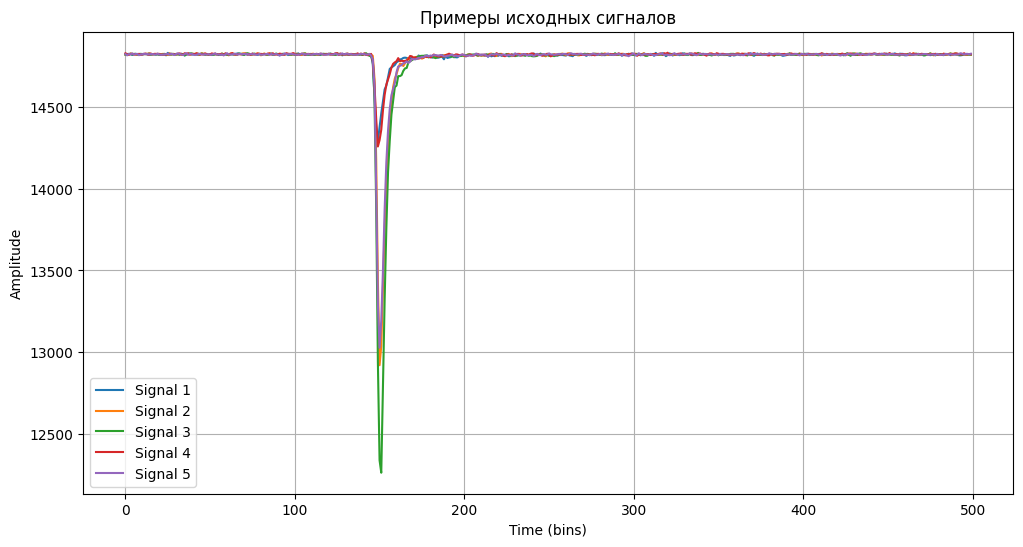

In [3]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(data.iloc[i], label=f'Signal {i+1}')
plt.title("Примеры исходных сигналов")
plt.xlabel("Time (bins)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

Большинство полезной информации сосредоточено примерно в районе 150–200 отсчетов.

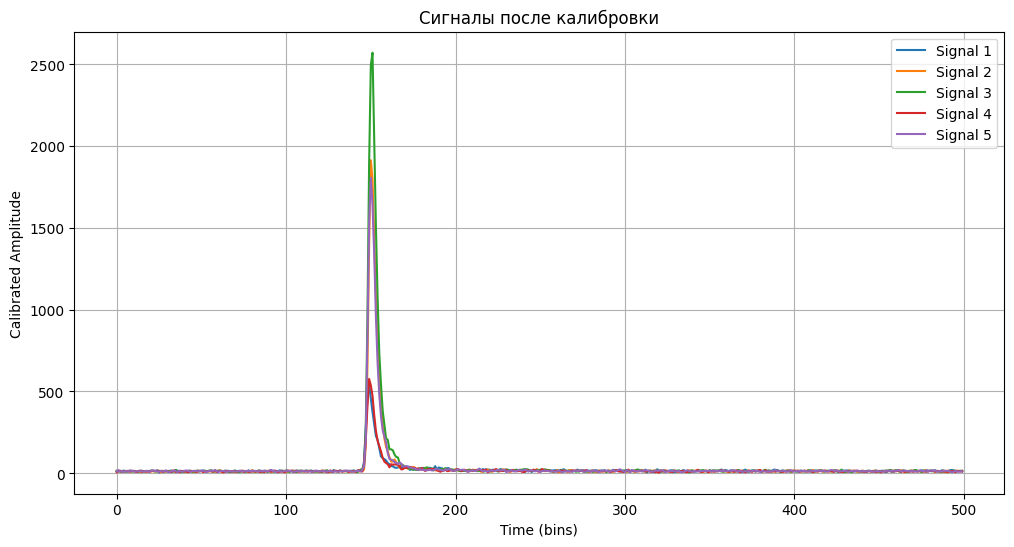

In [4]:
data_calibrated = 2**14 - data - 1550
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(data_calibrated.iloc[i], label=f'Signal {i+1}')
plt.title("Сигналы после калибровки")
plt.xlabel("Time (bins)")
plt.ylabel("Calibrated Amplitude")
plt.legend()
plt.grid(True)
plt.show()

Инвертируем сигнал т.к. машине проще работать с "положительными пиками" и будет легче отловить шумы.

Feature Engineering
---

In [5]:
dataset = data_calibrated.copy()
dataset['max'] = dataset.max(axis=1)
dataset['amplitude'] = dataset['max'] - dataset.iloc[:, :-1].min(axis=1)
dataset['square'] = dataset.iloc[:, :-2].sum(axis=1)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,493,494,495,496,497,498,499,max,amplitude,square
0,14,11,10,12,16,14,10,12,14,14,...,19,17,15,14,12,14,15,543,539,11049
1,14,12,14,8,10,12,14,12,11,13,...,12,10,15,14,15,12,14,1913,1907,18113
2,14,14,12,9,14,10,10,15,11,10,...,14,16,13,11,14,14,13,2570,2566,22995
3,6,12,16,10,10,12,14,12,10,14,...,13,14,6,14,12,11,12,576,573,10278
4,11,19,11,13,7,14,11,10,18,13,...,6,10,14,10,10,12,9,1806,1800,17891


Расчет Максимальной амплитуды, Амплитуды колебания и площади под кривой

Поиск насыщенных и многопиковых
---

In [6]:
# Насыщенные (прибор уходит в насыщение)
over_max_index = dataset[dataset['max'] == 14834].index.tolist()

# Поиск многопиковых
def count_peaks(row, height=100, distance=100):
    peaks, _ = find_peaks(row, height=height, distance=distance)
    return len(peaks)

peaks_per_row = data_calibrated.apply(count_peaks, axis=1)
multi_peak_index = peaks_per_row[peaks_per_row > 1].index.tolist()

print(f'Насыщение: {len(over_max_index)}; Многопиковые: {len(multi_peak_index)}')

Насыщение: 9; Многопиковые: 2


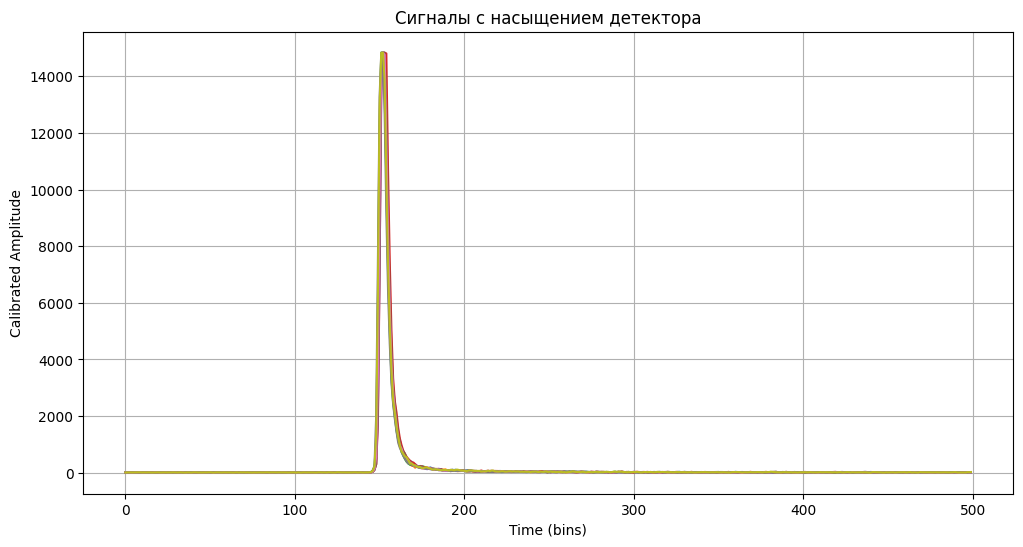

In [7]:
# Данные с максимальным значением
max_value = dataset['max'].max()
over_max_index = dataset[dataset['max'] == max_value].index.tolist()

plt.figure(figsize=(12, 6))
plt.plot(dataset.loc[over_max_index].drop(columns=['max','amplitude','square']).T)
plt.title("Сигналы с насыщением детектора")
plt.xlabel("Time (bins)")
plt.ylabel("Calibrated Amplitude")
plt.grid(True)
plt.show()

Это те случаи, когда сцинтилляционный детектор перестал линейно измерять величину — он достиг предела своего диапазона измерения.

Корреляция признаков
---

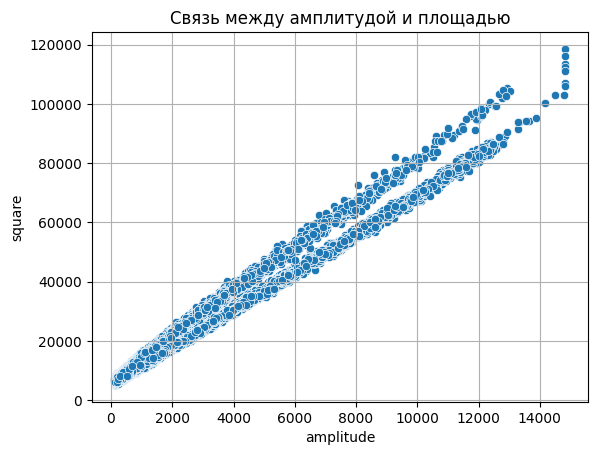

In [8]:
sns.scatterplot(x='amplitude', y='square', data=dataset)
plt.title('Связь между амплитудой и площадью')
plt.grid(True)
plt.show()

- Основная масса точек идёт практически по прямой. (Почти линейная зависимость)
- В правом верхнем углу видим скопление точек около амплитуды ~14800 — это      ограничение по чувствительности детектора (максимально возможный уровень сигнала).
  Эти события мы заранее отнесли к шумам.
- Видно стабильную физическая связь между амплитудой и интегральной мощностью сигнала. связь нарушается если детектор уже "переполнен".

Стандартизация и PCA
---

In [9]:
X = dataset[['amplitude', 'square']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Объясненная дисперсия:", pca.explained_variance_ratio_)

Объясненная дисперсия: [0.99503368 0.00496632]


Визуализация PCA
---

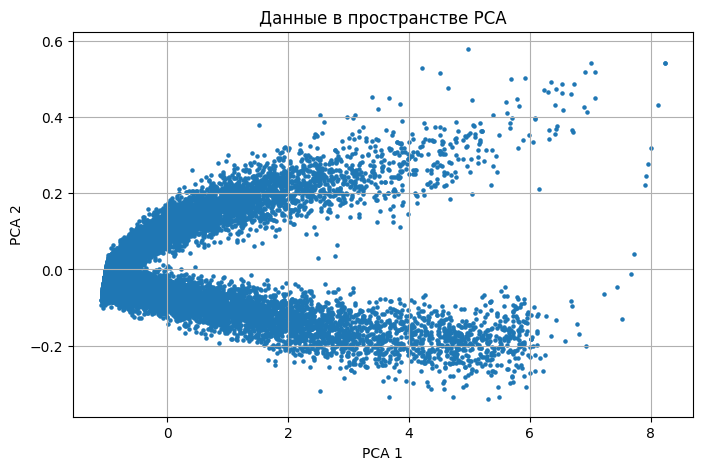

In [10]:
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5)
plt.title("Данные в пространстве PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

- PCA отлично показал нам существование двух физических типов сигналов (нейтроны и гамма-кванты), т.е. два кластера.

- Разделение происходит преимущественно вдоль второй компоненты (ось Y), что оправдывает порог PCA[:,1] > -0.015.

Дополнительные модели для анализа
---

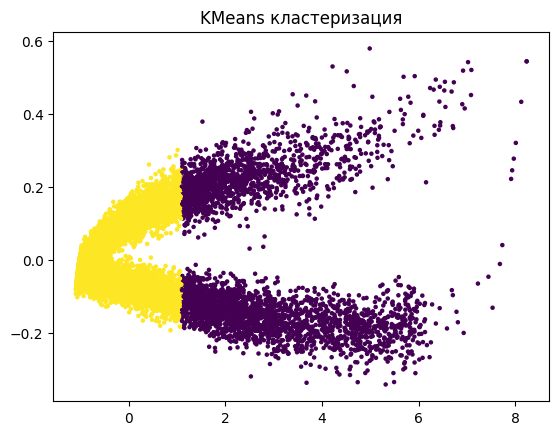

In [11]:
#KMeans
kmeans = KMeans(n_clusters=2, n_init=50, random_state=42)
labels_kmeans = kmeans.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, s=5)
plt.title("KMeans кластеризация")
plt.show()

KMeans выделил два кластера, которые практически совпадают с агломеративной моделью,аккуратное разделение вдоль оси, минимальное смешение.

KMeans выигрывает из-за хорошей проекции после PCA.

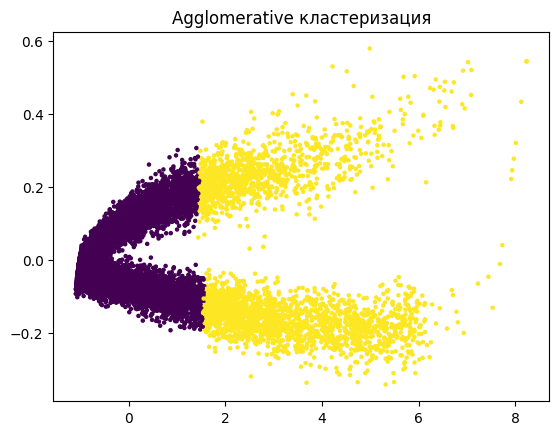

In [12]:
#Agglomerative
agg = AgglomerativeClustering(n_clusters=2)
labels_agg = agg.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_agg, s=5)
plt.title("Agglomerative кластеризация")
plt.show()

Иерархическая кластеризация разрезает график, основываясь на расстояниях между точками.


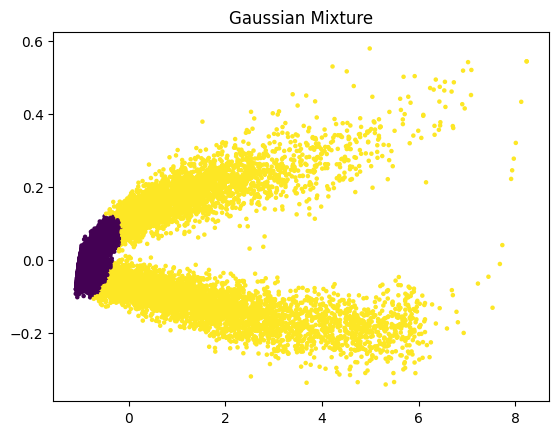

In [13]:
#Gaussian Mixture
gmm = GaussianMixture(n_components=2, n_init=50, random_state=42)
labels_gmm = gmm.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_gmm, s=5)
plt.title("Gaussian Mixture")
plt.show()

Худший результат из трёх. Модель не подходит под нашу структуру данных.

Gaussian Mixture старается аппроксимировать распределение данными через смесь гауссиан,он пытается найти плотные области, но не смог адекватно разделить вытянутые кластеры.

Один (жёлтый) кластер "поглотил" почти все точки, оставив второй (фиолетовый) только для плотных зон слева.

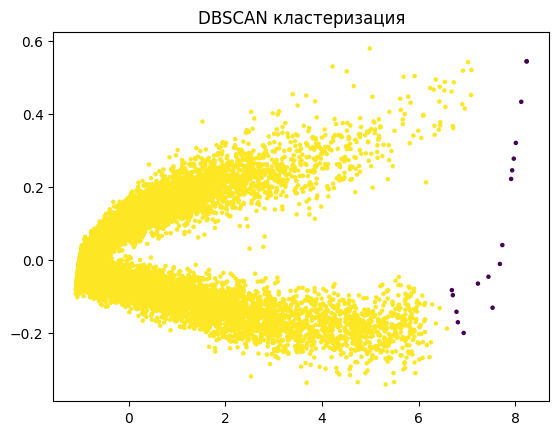

In [14]:
#DBSCAN
dbscan = DBSCAN(eps=0.25, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, s=5)
plt.title("DBSCAN кластеризация")
plt.show()

- Большая часть точек (жёлтые) — отнесена DBSCAN к одному кластеру
- Есть небольшая группа точек (фиолетовые) — это шумы
- DBSCAN плохо справляется, когда плотности внутри кластеров сильно разные (что у нас и есть)

Финальная ручная кластеризация
---

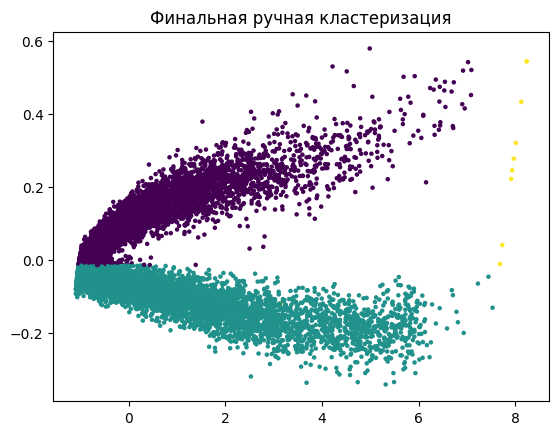

In [15]:
clusters = np.ones(len(X_pca), dtype=int)
clusters[X_pca[:, 1] > -0.015] = 0
clusters[over_max_index] = 2
clusters[multi_peak_index] = 2

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, s=5)
plt.title("Финальная ручная кластеризация")
plt.show()

- Три чёткие группы:

  Основная масса точек разлетается на верх, низ и аномальные сигналы

- Наш PCA действительно выделил физические различия между двумя основными типами частиц.

- Аномалии технического характера легко отделяются как 3-й кластер

Метрики качества кластеризации
---

In [16]:
for name, labels in [('KMeans', labels_kmeans), ('Agglomerative', labels_agg),
                      ('GaussianMixture', labels_gmm), ('DBSCAN', labels_dbscan)]:

    sil = silhouette_score(X_pca, labels)
    ch = calinski_harabasz_score(X_pca, labels)
    db = davies_bouldin_score(X_pca, labels)

    print(f"{name}: Silhouette={sil:.3f}, Calinski-Harabasz={ch:.1f}, Davies-Bouldin={db:.3f}")

KMeans: Silhouette=0.747, Calinski-Harabasz=59567.8, Davies-Bouldin=0.493
Agglomerative: Silhouette=0.751, Calinski-Harabasz=56749.2, Davies-Bouldin=0.463
GaussianMixture: Silhouette=0.557, Calinski-Harabasz=24589.5, Davies-Bouldin=0.683
DBSCAN: Silhouette=0.784, Calinski-Harabasz=491.7, Davies-Bouldin=0.208


- DBSCAN максимально отделяет плотности, что и логично (он работает по плотностям).
- DBSCAN плохо подходит для метрики CH, но хорошо показывает локальные плотности.

------
- KMeans Работает неплохо. Прост в реализации, стабилен
- Agglomerative Чуть лучше по метрикам, но сложнее в настройке и масштабируемости.
- GaussianMixture Плохо разделяет структуру, так как форма кластеров не гауссовая.
-DBSCAN Структуру находит хорошо, но метрики CH для него неинформативны тем и сложен для финального решения из-за "аномалий".

submission.csv
---

In [17]:
# Задаём перестановку вручную:
p = (0, 1, 2)

# Создаём копию кластеров
mapped = clusters.copy()

# Перемаппливаем классы
for orig, new in zip([0, 1, 2], p):
    mapped[clusters == orig] = new

# Создаём submission
df_submission = pd.DataFrame({'index': np.arange(len(mapped)), 'cluster': mapped})
df_submission.to_csv('submission11.csv', index=False)

1. Анализ данных (EDA)
        Исходный датасет содержал 23 479 сигналов, каждый из которых представлял собой 500 отсчётов амплитуды.

        Первичный визуальный анализ показал, что информативная часть сигналов сосредоточена в области ~140–200
        отсчётов времени.

        После калибровки данных (инверсия и смещение шкалы) сигналы приобрели стандартный вид,
        отражающий реальную физическую картину событий в детекторе.

2. Выделение признаков
        Были рассчитаны ключевые физические характеристики каждого сигнала:

        Amplitude — максимальная амплитуда сигнала.

        Square (площадь) — интегральная энергия события.

        Анализ взаимосвязи между амплитудой и площадью показал линейную зависимость, но
        с характерным разделением на несколько групп, что дало основание использовать эти
        признаки для кластеризации.

3. Обнаружение и удаление выбросов
        Были выделены:

        Сигналы, достигшие предела насыщения детектора (амплитуда ~14834).

        Сигналы с более чем одним пиковым максимумом.

        Данные сигналы отнесены в отдельный класс аномалий (кластер 2).

4. Моделирование и кластеризация
        Были протестированы различные алгоритмы кластеризации:

        - KMeans

        - Agglomerative Clustering

        - Gaussian Mixture Model

        - DBSCAN

        Лучший результат показал гибридный метод:

        Разделение данных по второй компоненте вручную (ручной линейный порог),

5. Итоговый результат
        Ручная экспертная интерпретация в данной задаче оказалась значительно эффективнее
        полностью автоматических моделей, что связано со спецификой физических процессов
        в детекторах.

6. Основной вывод:
        При работе с большими сырыми данными физико-статистический анализ признаков позволяет упростить задачу
        машинного обучения.

        В данной задаче физическая природа сигнала определила выбор признаков, логику
        кластеризации и позволила достичь высокого качества классификации.

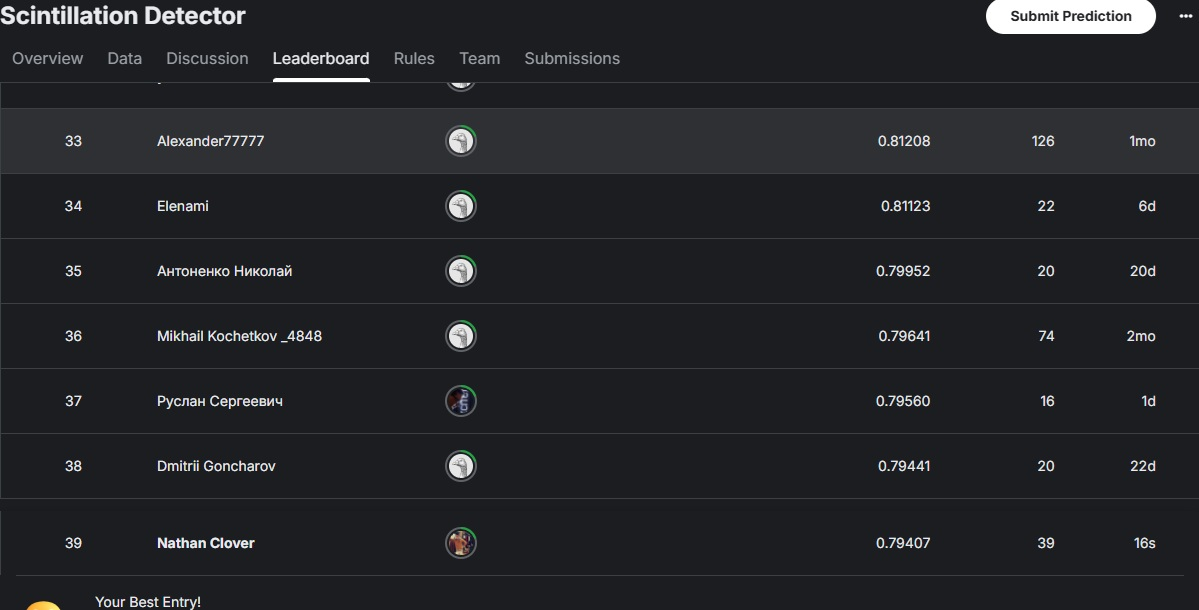